In [1]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [1]:
# Import all packages

import numpy as np
import itkConfig
itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [5]:
# Helper Functions

def subsample_points(inputmesh, mesh_sub_sample_points):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)

    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [19]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [75]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [76]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [77]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [5]:
sample = vtk.vtkPolyDataPointSampler()
sample.SetInputData(m1)
sample.SetGenerateEdgePoints(0)
sample.SetGenerateInteriorPoints(0)
sample.SetPointGenerationModeToRegular()
sample.SetDistance(0.1)
sample.Update()

sampled_points = sample.GetOutput()

print(m1.GetNumberOfPoints())
print(sampled_points.GetNumberOfPoints())

2209640
2209640


In [15]:
vtk_data_array = numpy_support.numpy_to_vtk(num_array=as_numpy_sampled,
                                            deep=True,
                                            array_type=vtk.VTK_FLOAT)
points2 = vtk.vtkPoints()
points2.SetData(vtk_data_array)

In [16]:
poly1 = vtk.vtkPolyData()
poly1.SetPoints(points2)

In [24]:
print(as_numpy_sampled.shape)
print(as_numpy_sampled)

(10000, 3)
[[ -19.032843  -62.61089    59.35268 ]
 [-102.698235  -36.72439   102.16699 ]
 [ -62.66175  -118.70344   112.004196]
 ...
 [ -72.941345 -124.75717    79.54381 ]
 [ -48.884876  -20.545244   62.336174]
 [ -86.15137  -143.80577    69.43055 ]]


In [21]:
f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(m1)
f.Update()
m1d = f.GetOutput()

f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(m2)
f.Update()
m2d = f.GetOutput()

print(m1d.GetNumberOfPoints())
print(m2d.GetNumberOfPoints())

242246
439173


In [14]:
number_of_rows = 10000

random_indices = np.random.choice(as_numpy.shape[0], 
                                  size=number_of_rows, 
                                  replace=False)
as_numpy_sampled = as_numpy[random_indices, :]

print(as_numpy_sampled.shape)

(10000, 3)


In [ ]:
itkwidgets.view(geometries=[fixedMesh, movingMesh])

In [32]:
# Perform RANSAC ICP

def ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergance_value):
    all_points1 = itk.array_from_vector_container(movingMesh.GetPoints())
    all_points2 = itk.array_from_vector_container(fixedMesh.GetPoints())
    
    # Create Meshes with reduced number of points
    mesh_fixed  = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()
    
    random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
    p1 = all_points1[random_indices, :]
    mesh_fixed.SetPoints(itk.vector_container_from_array(p1.flatten()))
    
    random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
    p2 = all_points2[random_indices, :]
    mesh_moving.SetPoints(itk.vector_container_from_array(p2.flatten()))
    
    best_score = 100000
    best_result = None
    best_transform = None
    
    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    else:
        TransformType = itk.ScaleTransform[itk.D, 3]
    transform = TransformType.New()
    transform.SetIdentity()
    
    e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
    
    # For reproduciblity
    np.random.seed(5)
    for i in range(number_of_iterations):
        random_indices = np.random.choice(all_points1.shape[0], size=number_of_ransac_points)
        p1 = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0], size=number_of_ransac_points)
        p2 = all_points2[random_indices, :]

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(10)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 10 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        current_transform    = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(mesh_moving, transform=current_transform)

        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        
        if current_value < best_score:
            best_score     = current_value
            best_result    = itk_transformed_mesh
            best_transform = current_transform

        if convergance_value > 0 and best_score < convergance_value:
            break
    
    print('Best Score ', best_score)
    itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=best_transform)
    return itk_transformed_mesh


#movingMesh = itk.meshread('/data/Apedata/apedata/apes/models/gorilla/USNM252577-Cranium.vtk')
#fixedMesh  = itk.meshread('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.vtk')

movingMesh = itk.meshread('movingMesh.vtk')
fixedMesh  = itk.meshread('fixedMesh.vtk')

number_of_iterations    = 2000
number_of_ransac_points = 250
mesh_sub_sample_points  = 5000
convergence_value       = 6
transform_type          = 0

import time
start_time = time.time()
itk_transformed_mesh = ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
itk.meshwrite(itk_transformed_mesh, 'ransacICPResult1.vtk')
end_time = time.time()

print(end_time - start_time)
# itk_transformed_mesh = itk.meshread('ransacICPResult1.vtk')
# number_of_iterations    = 100
# number_of_ransac_points = 1000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 0
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult2.vtk')


# number_of_iterations    = 100
# number_of_ransac_points = 10000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 1
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult3.vtk')

Best Score  13.128441318309916
65.535471200943


In [ ]:
# Perform Scale Transform

mesh_sub_sample_points = 10000

fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)
movingMesh = itk.meshread('movingMesh.vtk', itk.D)

ps1 = itk.Mesh[itk.D, 3].New()
ps2 = itk.Mesh[itk.D, 3].New()

all_points1 = itk.array_from_vector_container(fixedMesh.GetPoints())
all_points2 = itk.array_from_vector_container(movingMesh.GetPoints())

random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
p1 = all_points1[random_indices, :]

random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
p2 = all_points2[random_indices, :]

ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))


    
TransformType = itk.ScaleTransform[itk.D, 3]
        
transform = TransformType.New()
transform.SetIdentity()

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(movingMesh)
metric.SetFixedPointSet(fixedMesh)
metric.SetMovingTransform(transform)
metric.Initialize()

optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
optimizer.SetNumberOfIterations(10)
optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( 10 )
optimizer.SetMetric(metric)
optimizer.StartOptimization()

current_transform    = metric.GetTransform()
itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=current_transform)

In [ ]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    #all_points1 = itk.array_from_vector_container(fixedMesh.GetPoints())
    #all_points2 = itk.array_from_vector_container(movingMesh.GetPoints())

    #random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
    #p1 = all_points1[random_indices, :]

    #random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
    #p2 = all_points2[random_indices, :]

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization

        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[
            itk.D].New()
        optimizer.SetNumberOfIterations(10)
        optimizer.SetMaximumStepSizeInPhysicalUnits(0.5)
        optimizer.SetMinimumConvergenceValue(0.0)
        optimizer.SetConvergenceWindowSize(10)
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        #optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
        #         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        #         optimizer.SetNumberOfIterations(200)
        #         optimizer.SetLearningRate(0.1)
        #         optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        #         optimizer.SetMinimumConvergenceValue( 0.0 )
        #         optimizer.SetConvergenceWindowSize( 200 )
        #         optimizer.SetMetric(metric)
        #         optimizer.StartOptimization()

        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshAllPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))

    return final_result


import time

#movingMesh = itk.meshread('movingMesh.vtk')
#fixedMesh  = itk.meshread('fixedMesh.vtk')



#movingMesh = itk.meshread('/data/Apedata/apedata/apes/models/gorilla/USNM252577-Cranium.vtk')
#fixedMesh  = itk.meshread('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.vtk')

#for k in range(5):
number_of_iterations = 500
number_of_ransac_points = 500
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 2

movingMesh = readvtk('movingMesh.vtk')
fixedMesh = readvtk('fixedMesh.vtk')

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())
movingMeshPoints = subsample_points(movingMesh, mesh_sub_sample_points)
fixedMeshPoints = subsample_points(fixedMesh, mesh_sub_sample_points)

print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)
print(movingMeshAllPoints.shape)

start_time = time.time()
itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                             movingMeshAllPoints,
                                             number_of_iterations,
                                             mesh_sub_sample_points,
                                             number_of_ransac_points,
                                             transform_type, convergence_value)
end_time = time.time()

print(end_time - start_time)
print('itk_transformed_points shape ', itk_transformed_points.shape)

itk_transformed_mesh = itk.meshread('movingMesh.vtk')

#itk_transformed_mesh = itk.Mesh.D3.New()
itk_transformed_mesh.SetPoints(
    itk.vector_container_from_array(itk_transformed_points.flatten()))

w1 = itk.MeshFileWriter[type(itk_transformed_mesh)].New()
w1.SetFileName('ransacICPResult2_b.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(itk_transformed_mesh)
w1.Update()


fixedMesh = itk.meshread('fixedMesh.vtk')
e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(mesh_fixed)
e_metric.SetMovingPointSet(itk_transformed_mesh)
e_metric.Initialize()

# number_of_iterations    = 50
# number_of_ransac_points = 20000
# mesh_sub_sample_points  = 50000
# convergence_value       = 3pran

# transform_type          = 0

# start_time = time.time()
# itk_transformed_mesh = ransac_icp_parallel(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# end_time = time.time()
# print(end_time - start_time)

# w1 = itk.MeshFileWriter[type(itk_transformed_mesh)].New()
# w1.SetFileName('ransacICPResult2.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(itk_transformed_mesh)
# w1.Update()

In [6]:
mesh_fixed = itk.Mesh.D3.New()#itk.meshread('fixedMesh.vtk', itk.D)
itk_transformed_mesh = itk.Mesh.D3.New()#itk.meshread('ransacICPResult2_b.vtk', itk.D)

mesh_fixed.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))
itk_transformed_mesh.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten()))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(mesh_fixed)
e_metric.SetMovingPointSet(itk_transformed_mesh)
e_metric.Initialize()

print(e_metric.GetValue())

5.559841893722685


In [ ]:
itkwidgets.view(point_sets=[mesh_fixed, itk_transformed_mesh])

In [3]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m3 = readvtk('ransacICPResult2_b_check.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/TargetPointcloud.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SourcePointcloud.vtk')

#m1 = readply('USNM252577-Cranium_8.ply')
#m2 = readply('USNM145303-Cranium_9.ply')
#m3 = readply('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.ply')

#m3 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')

#m1 = readply('/data/Apedata/apedata/experiment/USNM145303-Cranium_1.ply')
#m2 = readply('/data/Apedata/apedata/experiment/USNM252577-Cranium.ply')
#m3 = readvtk('/data/Apedata/apedata/experiment/WarpedSourceMesh.vtk')

#print(m1.GetNumberOfPoints())
#print(m2.GetNumberOfPoints())
#print(m3.GetNumberOfPoints())
#print(m4.GetNumberOfPoints())

#view(point_sets=[movingMeshPoints, fixedMeshPoints])
#view(geometries=[m1, m2, m4])
#view(geometries=[m1, m2, m3, m4])
#view(geometries=[m1, m2, m3])
view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
itkwidgets.view(point_sets=[fixedMeshPoints, movingMeshPoints])

In [21]:
# Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

number_of_ransac_points = 500
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 2


FixedImageType = itk.Image[PixelType, Dimension]

# Read the meshes
fixedMesh  = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
movingMesh = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

movingMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData()))

fixedMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    fixedMesh.GetPoints().GetData()))

print(movingMeshAllPoints.shape)
print(fixedMeshAllPoints.shape)

movingMeshPoints = subsample_points(movingMesh, mesh_sub_sample_points)
fixedMeshPoints = subsample_points(fixedMesh, mesh_sub_sample_points)

print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)



# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))



# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

#all_points = np.concatenate([itk.array_from_vector_container(movingPS.GetPoints()), itk.array_from_vector_container(movingPS.GetPoints())])

bounding_box.SetPoints(fixedPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()



# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 10
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



# Registration Loop
numOfIterations = 10000
maxStep = 1
learningRate = 1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(1)
metric.SetEvaluationKNeighborhood(100)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()


# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingPS.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingPS.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())


# Write the mesh to disk
movingMeshITK = itk.meshread('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk', itk.D)
numberOfPoints = movingMeshITK.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))
    

w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
w1.SetFileName('ransacICPResult2_b_check.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMeshITK)
w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

(3277652, 3)
(2209640, 3)
(5000, 3)
(5000, 3)
Spacing  2.4050534768612737
minBounds  [-133.69621277 -189.3291626    26.28061676]
maxBounds  [-13.34983444  -9.35602093 131.01475525]
Metric Created
Metric: -0.036719067
Metric: -0.036731968
Metric: -0.036758729
Metric: -0.036793302
Metric: -0.036794701
Metric: -0.036801995
Metric: -0.036809537
Metric: -0.036822858
Metric: -0.036836515
Metric: -0.036853673
Metric: -0.036870904
Metric: -0.036890343
Metric: -0.036911043
Metric: -0.036932475
Metric: -0.036954165
Metric: -0.036976413
Metric: -0.036998998
Metric: -0.037021423
Metric: -0.037042705
Metric: -0.037062182
Metric: -0.037078946
Metric: -0.037093888
Metric: -0.037104539
Metric: -0.037112499
Metric: -0.037115058
Metric: -0.03711506
Metric: -0.03711341
Metric: -0.037109926
Metric: -0.037109289
Metric: -0.037113729
Metric: -0.037119436
Metric: -0.037128415
Metric: -0.037141932
Metric: -0.037156257
Metric: -0.037172298
Metric: -0.037187454
Metric: -0.037208326
Metric: -0.037217058
Metric: 

Metric: -0.039961879
Metric: -0.039968269
Metric: -0.039972693
Metric: -0.039976768
Metric: -0.039981152
Metric: -0.039986028
Metric: -0.039991374
Metric: -0.039997117
Metric: -0.040003173
Metric: -0.04000952
Metric: -0.040016147
Metric: -0.040023084
Metric: -0.040030351
Metric: -0.040037974
Metric: -0.040045956
Metric: -0.040054337
Metric: -0.040059426
Metric: -0.040065374
Metric: -0.040072186
Metric: -0.040079875
Metric: -0.040088454
Metric: -0.040097901
Metric: -0.040108143
Metric: -0.040119085
Metric: -0.040130612
Metric: -0.04014261
Metric: -0.040154978
Metric: -0.040167668
Metric: -0.040180637
Metric: -0.040193892
Metric: -0.040207387
Metric: -0.040221156
Metric: -0.040235171
Metric: -0.040253157
Metric: -0.040271971
Metric: -0.040288525
Metric: -0.040301496
Metric: -0.040314453
Metric: -0.040327789
Metric: -0.040341421
Metric: -0.040355126
Metric: -0.040368665
Metric: -0.040381878
Metric: -0.04039476
Metric: -0.04040733
Metric: -0.040419627
Metric: -0.040431672
Metric: -0.040443

Metric: -0.044858781
Metric: -0.04486698
Metric: -0.044869829
Metric: -0.044877856
Metric: -0.044880941
Metric: -0.044888715
Metric: -0.044892087
Metric: -0.0448995
Metric: -0.044903136
Metric: -0.044910086
Metric: -0.044913933
Metric: -0.044920329
Metric: -0.044924264
Metric: -0.044930012
Metric: -0.044933889
Metric: -0.044938883
Metric: -0.044942581
Metric: -0.04494679
Metric: -0.044950275
Metric: -0.044953908
Metric: -0.044957331
Metric: -0.044960815
Metric: -0.044964357
Metric: -0.044968003
Metric: -0.044971781
Metric: -0.0449757
Metric: -0.044979772
Metric: -0.044983958
Metric: -0.044988245
Metric: -0.044992552
Metric: -0.044996815
Metric: -0.045000946
Metric: -0.045004862
Metric: -0.045008499
Metric: -0.045011812
Metric: -0.045014778
Metric: -0.045017428
Metric: -0.045019836
Metric: -0.045022055
Metric: -0.045024198
Metric: -0.045026318
Metric: -0.045028469
Metric: -0.045030668
Metric: -0.045032921
Metric: -0.045035195
Metric: -0.045037466
Metric: -0.045039708
Metric: -0.04504188

Metric: -0.045566713
Metric: -0.045565313
Metric: -0.045563997
Metric: -0.045562764
Metric: -0.045561651
Metric: -0.045560689
Metric: -0.045559885
Metric: -0.045559266
Metric: -0.045558867
Metric: -0.045558748
Metric: -0.045559008
Metric: -0.045559196
Metric: -0.045559065
Metric: -0.045558798
Metric: -0.045558407
Metric: -0.045557931
Metric: -0.0455574
Metric: -0.045556814
Metric: -0.045556191
Metric: -0.045555555
Metric: -0.04555489
Metric: -0.045554204
Metric: -0.045553517
Metric: -0.045552833
Metric: -0.045552136
Metric: -0.045551449
Metric: -0.045550781
Metric: -0.045550123
Metric: -0.045549502
Metric: -0.04554892
Metric: -0.04554839
Metric: -0.045547933
Metric: -0.045547558
Metric: -0.045547292
Metric: -0.045547153
Metric: -0.045547115
Metric: -0.045547145
Metric: -0.045547271
Metric: -0.045547538
Metric: -0.045548064
Metric: -0.045548963
Metric: -0.045550394
Metric: -0.045552437
Metric: -0.045555111
Metric: -0.045558371
Metric: -0.045562107
Metric: -0.0455662
Metric: -0.045570437

Metric: -0.047463512
Metric: -0.047465257
Metric: -0.047467181
Metric: -0.04746924
Metric: -0.047471398
Metric: -0.047473608
Metric: -0.04747582
Metric: -0.047477996
Metric: -0.047480132
Metric: -0.047482205
Metric: -0.047484228
Metric: -0.047486182
Metric: -0.047488082
Metric: -0.047489927
Metric: -0.047491733
Metric: -0.047493508
Metric: -0.047495326
Metric: -0.047497137
Metric: -0.047498963
Metric: -0.047500832
Metric: -0.047502759
Metric: -0.047504759
Metric: -0.047506833
Metric: -0.04750898
Metric: -0.04751121
Metric: -0.04751349
Metric: -0.047515814
Metric: -0.047518168
Metric: -0.047520542
Metric: -0.047522933
Metric: -0.047525341
Metric: -0.047527764
Metric: -0.047530211
Metric: -0.047532701
Metric: -0.047535241
Metric: -0.047537863
Metric: -0.047540542
Metric: -0.047543302
Metric: -0.047546136
Metric: -0.04754902
Metric: -0.04755192
Metric: -0.047554821
Metric: -0.047557688
Metric: -0.047560509
Metric: -0.047563293
Metric: -0.047566041
Metric: -0.047568783
Metric: -0.047571527

Metric: -0.049129649
Metric: -0.049138727
Metric: -0.04914768
Metric: -0.049156503
Metric: -0.049165189
Metric: -0.049173751
Metric: -0.049182185
Metric: -0.0491905
Metric: -0.04919873
Metric: -0.049206889
Metric: -0.049215007
Metric: -0.04922315
Metric: -0.049231326
Metric: -0.049239613
Metric: -0.049248048
Metric: -0.04925667
Metric: -0.04926554
Metric: -0.049274682
Metric: -0.049284439
Metric: -0.049294496
Metric: -0.04930486
Metric: -0.049315517
Metric: -0.049326454
Metric: -0.049337637
Metric: -0.049349032
Metric: -0.049360619
Metric: -0.049372384
Metric: -0.049384299
Metric: -0.04939637
Metric: -0.04940859
Metric: -0.04942095
Metric: -0.049433899
Metric: -0.049446913
Metric: -0.049460317
Metric: -0.04947454
Metric: -0.049486974
Metric: -0.049500672
Metric: -0.04951379
Metric: -0.04952704
Metric: -0.049540045
Metric: -0.049552799
Metric: -0.04956515
Metric: -0.049577017
Metric: -0.049588399
Metric: -0.049599551
Metric: -0.049611079
Metric: -0.049623106
Metric: -0.04963483
Metric: 

Metric: -0.05155094
Metric: -0.051555502
Metric: -0.05155993
Metric: -0.051564265
Metric: -0.051568545
Metric: -0.051572803
Metric: -0.051577056
Metric: -0.051581337
Metric: -0.051585639
Metric: -0.051589983
Metric: -0.051594356
Metric: -0.051598742
Metric: -0.051603152
Metric: -0.051607559
Metric: -0.051611956
Metric: -0.051616352
Metric: -0.051620726
Metric: -0.051625073
Metric: -0.051629391
Metric: -0.051629576
Metric: -0.051631314
Metric: -0.0516343
Metric: -0.051637915
Metric: -0.051641821
Metric: -0.051645864
Metric: -0.051649973
Metric: -0.051654129
Metric: -0.051658291
Metric: -0.051662424
Metric: -0.051666521
Metric: -0.051670551
Metric: -0.051674477
Metric: -0.051678277
Metric: -0.051681922
Metric: -0.051685399
Metric: -0.051688696
Metric: -0.051691843
Metric: -0.05169484
Metric: -0.05169774
Metric: -0.051700575
Metric: -0.051703401
Metric: -0.051706261
Metric: -0.0517092
Metric: -0.051712256
Metric: -0.051715456
Metric: -0.051718824
Metric: -0.051722362
Metric: -0.051726034


Metric: -0.051186409
Metric: -0.051185067
Metric: -0.051183705
Metric: -0.05118232
Metric: -0.051180923
Metric: -0.05117951
Metric: -0.051178089
Metric: -0.051176669
Metric: -0.051175239
Metric: -0.051173816
Metric: -0.051172405
Metric: -0.051171
Metric: -0.051169623
Metric: -0.051168259
Metric: -0.051166921
Metric: -0.051165609
Metric: -0.051164336
Metric: -0.051163091
Metric: -0.05116189
Metric: -0.051160715
Metric: -0.051159583
Metric: -0.051158484
Metric: -0.051157431
Metric: -0.051156401
Metric: -0.051155409
Metric: -0.051154444
Metric: -0.051153505
Metric: -0.051152594
Metric: -0.051151701
Metric: -0.051150819
Metric: -0.051149942
Metric: -0.051149091
Metric: -0.051148235
Metric: -0.051147385
Metric: -0.051146532
Metric: -0.051145684
Metric: -0.051144811
Metric: -0.051143947
Metric: -0.051143057
Metric: -0.051142153
Metric: -0.051141239
Metric: -0.051140297
Metric: -0.051139334
Metric: -0.051138351
Metric: -0.051137337
Metric: -0.051136308
Metric: -0.051135239
Metric: -0.05113414

Metric: -0.050322882
Metric: -0.050323572
Metric: -0.050324272
Metric: -0.050325005
Metric: -0.050325786
Metric: -0.050326652
Metric: -0.050327617
Metric: -0.050328739
Metric: -0.050330027
Metric: -0.050331499
Metric: -0.050333127
Metric: -0.050334891
Metric: -0.05033674
Metric: -0.050338629
Metric: -0.050340523
Metric: -0.050342399
Metric: -0.050344199
Metric: -0.050345919
Metric: -0.050347541
Metric: -0.050349047
Metric: -0.050350443
Metric: -0.05035171
Metric: -0.05035286
Metric: -0.050353884
Metric: -0.050354799
Metric: -0.050355575
Metric: -0.050356223
Metric: -0.050356746
Metric: -0.050357133
Metric: -0.050357393
Metric: -0.050357522
Metric: -0.050357539
Metric: -0.050357445
Metric: -0.050357253
Metric: -0.050356987
Metric: -0.05035666
Metric: -0.050356273
Metric: -0.050355849
Metric: -0.0503554
Metric: -0.05035494
Metric: -0.050354468
Metric: -0.05035399
Metric: -0.050353506
Metric: -0.050353042
Metric: -0.05035258
Metric: -0.050352138
Metric: -0.050351709
Metric: -0.05035129
Me

Metric: -0.049835834
Metric: -0.049831707
Metric: -0.049827583
Metric: -0.049823473
Metric: -0.049819372
Metric: -0.049815283
Metric: -0.049811199
Metric: -0.049807131
Metric: -0.049803078
Metric: -0.049799047
Metric: -0.049795026
Metric: -0.049791035
Metric: -0.049787077
Metric: -0.049783134
Metric: -0.04977923
Metric: -0.049775361
Metric: -0.049771517
Metric: -0.049767723
Metric: -0.049763955
Metric: -0.049760225
Metric: -0.04975655
Metric: -0.04975292
Metric: -0.049749336
Metric: -0.049745801
Metric: -0.04974231
Metric: -0.049738876
Metric: -0.04973548
Metric: -0.049732146
Metric: -0.049728874
Metric: -0.049726359
Metric: -0.049723845
Metric: -0.049721307
Metric: -0.049718761
Metric: -0.049716198
Metric: -0.049713598
Metric: -0.049710972
Metric: -0.049708323
Metric: -0.049705636
Metric: -0.049702936
Metric: -0.049700247
Metric: -0.049697608
Metric: -0.049695055
Metric: -0.049692627
Metric: -0.049690311
Metric: -0.049688112
Metric: -0.049686004
Metric: -0.049683998
Metric: -0.0496820

Metric: -0.049907882
Metric: -0.049910727
Metric: -0.049913602
Metric: -0.049916494
Metric: -0.049919416
Metric: -0.049922349
Metric: -0.049925311
Metric: -0.049928287
Metric: -0.049931284
Metric: -0.049934295
Metric: -0.049937327
Metric: -0.049940374
Metric: -0.049943434
Metric: -0.04994651
Metric: -0.049949596
Metric: -0.049952701
Metric: -0.049955813
Metric: -0.049958936
Metric: -0.049962074
Metric: -0.049965223
Metric: -0.049968369
Metric: -0.049971536
Metric: -0.049974698
Metric: -0.04997788
Metric: -0.049981055
Metric: -0.04998425
Metric: -0.049987445
Metric: -0.049990644
Metric: -0.049993843
Metric: -0.049997052
Metric: -0.050000272
Metric: -0.050003495
Metric: -0.050006708
Metric: -0.050009937
Metric: -0.050013173
Metric: -0.050016418
Metric: -0.050019653
Metric: -0.050022902
Metric: -0.050026157
Metric: -0.050029419
Metric: -0.050032681
Metric: -0.050035955
Metric: -0.050039228
Metric: -0.050042508
Metric: -0.050045798
Metric: -0.050049082
Metric: -0.05005238
Metric: -0.050055

Metric: -0.051055159
Metric: -0.051057236
Metric: -0.051059298
Metric: -0.051061332
Metric: -0.051063371
Metric: -0.051065368
Metric: -0.051067348
Metric: -0.051069299
Metric: -0.051071226
Metric: -0.05107311
Metric: -0.051074967
Metric: -0.051076786
Metric: -0.051078566
Metric: -0.051080311
Metric: -0.051082012
Metric: -0.051083679
Metric: -0.051085295
Metric: -0.051086874
Metric: -0.051088408
Metric: -0.051089899
Metric: -0.051091341
Metric: -0.051092751
Metric: -0.051094098
Metric: -0.051095413
Metric: -0.051096684
Metric: -0.051097911
Metric: -0.051099082
Metric: -0.051100217
Metric: -0.051101312
Metric: -0.051102344
Metric: -0.051103345
Metric: -0.05110429
Metric: -0.05110519
Metric: -0.05110605
Metric: -0.051106848
Metric: -0.051107608
Metric: -0.051108313
Metric: -0.051108969
Metric: -0.051109566
Metric: -0.051110116
Metric: -0.051110608
Metric: -0.05111104
Metric: -0.051111405
Metric: -0.051111722
Metric: -0.05111197
Metric: -0.051112147
Metric: -0.051112255
Metric: -0.05111228

Metric: -0.051229193
Metric: -0.051228934
Metric: -0.051228671
Metric: -0.0512284
Metric: -0.051228135
Metric: -0.051227857
Metric: -0.051227581
Metric: -0.051227303
Metric: -0.051227026
Metric: -0.051226748
Metric: -0.051226478
Metric: -0.05122621
Metric: -0.051225943
Metric: -0.051225682
Metric: -0.051225415
Metric: -0.051225168
Metric: -0.051224913
Metric: -0.051224671
Metric: -0.051224431
Metric: -0.051224194
Metric: -0.051223963
Metric: -0.051223737
Metric: -0.051223518
Metric: -0.051223303
Metric: -0.051223097
Metric: -0.051222897
Metric: -0.051222698
Metric: -0.051222514
Metric: -0.05122233
Metric: -0.051222165
Metric: -0.051221998
Metric: -0.051221834
Metric: -0.051221689
Metric: -0.051221549
Metric: -0.051221418
Metric: -0.05122129
Metric: -0.051221169
Metric: -0.05122107
Metric: -0.051220966
Metric: -0.05122088
Metric: -0.051220801
Metric: -0.051220717
Metric: -0.051220659
Metric: -0.051220605
Metric: -0.051220562
Metric: -0.051220523
Metric: -0.051220505
Metric: -0.051220484

Metric: -0.051563831
Metric: -0.051567458
Metric: -0.051571023
Metric: -0.051574552
Metric: -0.051578026
Metric: -0.051581441
Metric: -0.051584808
Metric: -0.051588124
Metric: -0.051591378
Metric: -0.05159458
Metric: -0.051597726
Metric: -0.051600805
Metric: -0.051603825
Metric: -0.051606772
Metric: -0.051609651
Metric: -0.051612456
Metric: -0.051615178
Metric: -0.051617809
Metric: -0.051620344
Metric: -0.05162278
Metric: -0.051625095
Metric: -0.051627316
Metric: -0.0516294
Metric: -0.051631365
Metric: -0.051633211
Metric: -0.051634936
Metric: -0.051636552
Metric: -0.051638061
Metric: -0.051639466
Metric: -0.051640781
Metric: -0.051642011
Metric: -0.051643157
Metric: -0.051644231
Metric: -0.051645249
Metric: -0.051646217
Metric: -0.051647136
Metric: -0.051648035
Metric: -0.051648904
Metric: -0.051649765
Metric: -0.051650634
Metric: -0.05165151
Metric: -0.051652419
Metric: -0.051653352
Metric: -0.051654336
Metric: -0.051655365
Metric: -0.051656462
Metric: -0.051657606
Metric: -0.0516588

Metric: -0.05219032
Metric: -0.052189853
Metric: -0.052189374
Metric: -0.052188864
Metric: -0.052188351
Metric: -0.052187808
Metric: -0.052187259
Metric: -0.052186679
Metric: -0.052186089
Metric: -0.052185486
Metric: -0.052184862
Metric: -0.052184226
Metric: -0.052183565
Metric: -0.052182898
Metric: -0.052182218
Metric: -0.052181519
Metric: -0.052180804
Metric: -0.052180081
Metric: -0.052179346
Metric: -0.052178596
Metric: -0.052177836
Metric: -0.052177066
Metric: -0.052176286
Metric: -0.052175499
Metric: -0.052174698
Metric: -0.052173884
Metric: -0.052173077
Metric: -0.052172255
Metric: -0.052171428
Metric: -0.052170589
Metric: -0.052169762
Metric: -0.05216892
Metric: -0.052168079
Metric: -0.052167225
Metric: -0.052166384
Metric: -0.052165533
Metric: -0.052164693
Metric: -0.052163842
Metric: -0.052163001
Metric: -0.052162158
Metric: -0.052161329
Metric: -0.052160488
Metric: -0.05215967
Metric: -0.052158849
Metric: -0.052158032
Metric: -0.052157234
Metric: -0.052156431
Metric: -0.05215

Metric: -0.05182671
Metric: -0.05182651
Metric: -0.051826493
Metric: -0.051826668
Metric: -0.051827031
Metric: -0.051827612
Metric: -0.051828388
Metric: -0.051829351
Metric: -0.051830502
Metric: -0.051831804
Metric: -0.051833242
Metric: -0.051834787
Metric: -0.05183642
Metric: -0.05183811
Metric: -0.051839852
Metric: -0.051841607
Metric: -0.051843375
Metric: -0.051845125
Metric: -0.051846865
Metric: -0.051848569
Metric: -0.051850227
Metric: -0.051851823
Metric: -0.051853372
Metric: -0.051854852
Metric: -0.051856256
Metric: -0.05185759
Metric: -0.05185884
Metric: -0.051859699
Metric: -0.051860485
Metric: -0.0518612
Metric: -0.051861841
Metric: -0.051862412
Metric: -0.051862917
Metric: -0.051863346
Metric: -0.051863725
Metric: -0.051864031
Metric: -0.051864302
Metric: -0.051864521
Metric: -0.051864696
Metric: -0.051864839
Metric: -0.051864955
Metric: -0.05186505
Metric: -0.051865135
Metric: -0.051865205
Metric: -0.051865293
Metric: -0.051865386
Metric: -0.051865498
Metric: -0.051865638
M

Metric: -0.051375035
Metric: -0.051375414
Metric: -0.051375798
Metric: -0.051376176
Metric: -0.051376544
Metric: -0.051376911
Metric: -0.051377269
Metric: -0.051377611
Metric: -0.05137795
Metric: -0.05137827
Metric: -0.051378576
Metric: -0.051378867
Metric: -0.051379141
Metric: -0.051379395
Metric: -0.051379641
Metric: -0.051379856
Metric: -0.051380062
Metric: -0.051380272
Metric: -0.051380456
Metric: -0.051380651
Metric: -0.051380842
Metric: -0.051381039
Metric: -0.051381244
Metric: -0.051381454
Metric: -0.05138168
Metric: -0.051381914
Metric: -0.051382171
Metric: -0.051382444
Metric: -0.051382727
Metric: -0.051383024
Metric: -0.051383333
Metric: -0.051383676
Metric: -0.051384022
Metric: -0.051382641
Metric: -0.051381275
Metric: -0.051379924
Metric: -0.051378574
Metric: -0.051377244
Metric: -0.05137593
Metric: -0.051374629
Metric: -0.051373356
Metric: -0.051372094
Metric: -0.051370869
Metric: -0.051369675
Metric: -0.051368524
Metric: -0.051367426
Metric: -0.051366394
Metric: -0.051365

Metric: -0.05144497
Metric: -0.051444024
Metric: -0.051443134
Metric: -0.051442285
Metric: -0.051441482
Metric: -0.051440721
Metric: -0.051439991
Metric: -0.051439308
Metric: -0.051438649
Metric: -0.051438016
Metric: -0.051437403
Metric: -0.051436813
Metric: -0.051436246
Metric: -0.05143569
Metric: -0.051435146
Metric: -0.051434615
Metric: -0.05143409
Metric: -0.05143357
Metric: -0.05143305
Metric: -0.051432531
Metric: -0.05143201
Metric: -0.051431491
Metric: -0.051430969
Metric: -0.051430445
Metric: -0.051429907
Metric: -0.051429365
Metric: -0.051428831
Metric: -0.051428281
Metric: -0.051427298
Metric: -0.051426326
Metric: -0.051425362
Metric: -0.051424395
Metric: -0.051423448
Metric: -0.051422516
Metric: -0.051421584
Metric: -0.051420672
Metric: -0.051419765
Metric: -0.051418871
Metric: -0.051418002
Metric: -0.051417153
Metric: -0.051416318
Metric: -0.051415508
Metric: -0.051414735
Metric: -0.051414001
Metric: -0.051413297
Metric: -0.051412641
Metric: -0.05141205
Metric: -0.051411515

Metric: -0.051421611
Metric: -0.051421839
Metric: -0.051422061
Metric: -0.051422293
Metric: -0.051422535
Metric: -0.051422773
Metric: -0.05142302
Metric: -0.051423278
Metric: -0.05142353
Metric: -0.051423789
Metric: -0.051424052
Metric: -0.051424328
Metric: -0.051424598
Metric: -0.051424877
Metric: -0.051425164
Metric: -0.051425441
Metric: -0.051425732
Metric: -0.051426017
Metric: -0.051426306
Metric: -0.051426603
Metric: -0.051426902
Metric: -0.051427203
Metric: -0.0514275
Metric: -0.0514278
Metric: -0.051428102
Metric: -0.051428397
Metric: -0.051428699
Metric: -0.051429001
Metric: -0.051429301
Metric: -0.051429598
Metric: -0.05142989
Metric: -0.051430189
Metric: -0.051430482
Metric: -0.051430775
Metric: -0.051431049
Metric: -0.051431327
Metric: -0.051431601
Metric: -0.051431864
Metric: -0.051432137
Metric: -0.051432399
Metric: -0.051432652
Metric: -0.051432888
Metric: -0.051433134
Metric: -0.051433371
Metric: -0.051433592
Metric: -0.051433821
Metric: -0.051434034
Metric: -0.051434246

Metric: -0.051276327
Metric: -0.051275063
Metric: -0.051273792
Metric: -0.051272509
Metric: -0.051271225
Metric: -0.051269944
Metric: -0.051268646
Metric: -0.051267343
Metric: -0.051266042
Metric: -0.051264723
Metric: -0.051263405
Metric: -0.051262072
Metric: -0.051260731
Metric: -0.051259375
Metric: -0.051258022
Metric: -0.051256644
Metric: -0.051255266
Metric: -0.051253876
Metric: -0.051252463
Metric: -0.05125104
Metric: -0.051249614
Metric: -0.051248169
Metric: -0.051246716
Metric: -0.051245244
Metric: -0.051243761
Metric: -0.051242265
Metric: -0.051240758
Metric: -0.051239235
Metric: -0.051237702
Metric: -0.051236157
Metric: -0.051234594
Metric: -0.051233027
Metric: -0.051231438
Metric: -0.051229846
Metric: -0.05122824
Metric: -0.05122663
Metric: -0.051225009
Metric: -0.05122338
Metric: -0.051221749
Metric: -0.051220114
Metric: -0.051218471
Metric: -0.051216827
Metric: -0.051215188
Metric: -0.051213544
Metric: -0.051211918
Metric: -0.051210292
Metric: -0.051208677
Metric: -0.051207

Metric: -0.051023646
Metric: -0.051023399
Metric: -0.051023179
Metric: -0.051023008
Metric: -0.051022896
Metric: -0.051022851
Metric: -0.05102287
Metric: -0.051022961
Metric: -0.051023121
Metric: -0.051023352
Metric: -0.051023636
Metric: -0.051024002
Metric: -0.051024414
Metric: -0.051024883
Metric: -0.051025403
Metric: -0.051025966
Metric: -0.051026575
Metric: -0.051027219
Metric: -0.051027908
Metric: -0.051028633
Metric: -0.051029411
Metric: -0.051030227
Metric: -0.051031097
Metric: -0.051032015
Metric: -0.051032981
Metric: -0.051034012
Metric: -0.051035105
Metric: -0.051036262
Metric: -0.051037491
Metric: -0.051038786
Metric: -0.051040146
Metric: -0.051041592
Metric: -0.051043103
Metric: -0.051044677
Metric: -0.051046326
Metric: -0.051048028
Metric: -0.051049782
Metric: -0.051051605
Metric: -0.051053453
Metric: -0.051055343
Metric: -0.051057262
Metric: -0.051059199
Metric: -0.051061162
Metric: -0.051063116
Metric: -0.05106509
Metric: -0.051067057
Metric: -0.05106902
Metric: -0.05107

Metric: -0.052089501
Metric: -0.052089448
Metric: -0.052089357
Metric: -0.052089224
Metric: -0.052089064
Metric: -0.052088884
Metric: -0.052088683
Metric: -0.052088473
Metric: -0.052088252
Metric: -0.052088028
Metric: -0.052087797
Metric: -0.052087573
Metric: -0.05208734
Metric: -0.052087114
Metric: -0.052086888
Metric: -0.052086664
Metric: -0.052086442
Metric: -0.052086221
Metric: -0.052086
Metric: -0.052085782
Metric: -0.052085556
Metric: -0.052085328
Metric: -0.052085085
Metric: -0.052084821
Metric: -0.052084537
Metric: -0.052084222
Metric: -0.052083872
Metric: -0.052083464
Metric: -0.052082987
Metric: -0.052082433
Metric: -0.052081784
Metric: -0.052081019
Metric: -0.052080122
Metric: -0.052079076
Metric: -0.052077867
Metric: -0.052076482
Metric: -0.052074914
Metric: -0.052073164
Metric: -0.052071243
Metric: -0.052069169
Metric: -0.052066994
Metric: -0.052064763
Metric: -0.052062523
Metric: -0.052060335
Metric: -0.052058228
Metric: -0.05205622
Metric: -0.052054322
Metric: -0.0520525

Metric: -0.052179297
Metric: -0.052180443
Metric: -0.052181602
Metric: -0.052182765
Metric: -0.052183932
Metric: -0.052185114
Metric: -0.052186305
Metric: -0.052187496
Metric: -0.052188727
Metric: -0.052189951
Metric: -0.0521912
Metric: -0.052192455
Metric: -0.052193748
Metric: -0.052195037
Metric: -0.052196363
Metric: -0.052197708
Metric: -0.052199073
Metric: -0.052200454
Metric: -0.052201878
Metric: -0.052203308
Metric: -0.052204771
Metric: -0.052206252
Metric: -0.05220775
Metric: -0.052209287
Metric: -0.052210836
Metric: -0.052212411
Metric: -0.052213999
Metric: -0.05221561
Metric: -0.052217237
Metric: -0.052218887
Metric: -0.052220543
Metric: -0.052222214
Metric: -0.052223896
Metric: -0.052225593
Metric: -0.052227302
Metric: -0.052229007
Metric: -0.052230724
Metric: -0.05223244
Metric: -0.052234161
Metric: -0.052235894
Metric: -0.052237621
Metric: -0.052239352
Metric: -0.052241086
Metric: -0.052242811
Metric: -0.052244536
Metric: -0.05224626
Metric: -0.052247983
Metric: -0.05224971

Metric: -0.052625641
Metric: -0.052630077
Metric: -0.052634541
Metric: -0.052639024
Metric: -0.052643514
Metric: -0.052648008
Metric: -0.052652493
Metric: -0.052656972
Metric: -0.052661448
Metric: -0.052665895
Metric: -0.052670329
Metric: -0.052674744
Metric: -0.052679129
Metric: -0.052683486
Metric: -0.052687818
Metric: -0.052692115
Metric: -0.052696374
Metric: -0.052700591
Metric: -0.052704768
Metric: -0.0527089
Metric: -0.052712989
Metric: -0.052717027
Metric: -0.052721016
Metric: -0.052724946
Metric: -0.052728836
Metric: -0.052732656
Metric: -0.052736442
Metric: -0.05274016
Metric: -0.052743829
Metric: -0.052747439
Metric: -0.052750997
Metric: -0.052754501
Metric: -0.052757957
Metric: -0.052761357
Metric: -0.052764713
Metric: -0.052768016
Metric: -0.052771273
Metric: -0.052774498
Metric: -0.052777674
Metric: -0.052780813
Metric: -0.052783926
Metric: -0.052787005
Metric: -0.05279006
Metric: -0.0527931
Metric: -0.052796116
Metric: -0.052799138
Metric: -0.052802142
Metric: -0.05280516

Metric: -0.053592942
Metric: -0.05359446
Metric: -0.053595984
Metric: -0.053597497
Metric: -0.053599033
Metric: -0.053600561
Metric: -0.053602096
Metric: -0.053603648
Metric: -0.053605201
Metric: -0.053606769
Metric: -0.05360835
Metric: -0.053609942
Metric: -0.053611551
Metric: -0.053613176
Metric: -0.053614817
Metric: -0.053616479
Metric: -0.053618165
Metric: -0.053619868
Metric: -0.053621587
Metric: -0.053623318
Metric: -0.053625091
Metric: -0.053626878
Metric: -0.053628671
Metric: -0.053630504
Metric: -0.053632345
Metric: -0.053634201
Metric: -0.053636091
Metric: -0.053637942
Metric: -0.053639773
Metric: -0.053641599
Metric: -0.053643428
Metric: -0.05364526
Metric: -0.053647078
Metric: -0.053648885
Metric: -0.053650688
Metric: -0.053652467
Metric: -0.053654228
Metric: -0.053655965
Metric: -0.053657673
Metric: -0.053659346
Metric: -0.053660984
Metric: -0.053662576
Metric: -0.053664125
Metric: -0.053665636
Metric: -0.053667091
Metric: -0.053668501
Metric: -0.053669851
Metric: -0.05367

Metric: -0.053765259
Metric: -0.053766475
Metric: -0.053767711
Metric: -0.05376894
Metric: -0.05377019
Metric: -0.053771451
Metric: -0.053772729
Metric: -0.053774012
Metric: -0.053775294
Metric: -0.053776591
Metric: -0.053777896
Metric: -0.053779199
Metric: -0.053780505
Metric: -0.053781823
Metric: -0.053783134
Metric: -0.053784438
Metric: -0.05378574
Metric: -0.053787045
Metric: -0.053788343
Metric: -0.053789628
Metric: -0.053790913
Metric: -0.053792187
Metric: -0.053793453
Metric: -0.053794703
Metric: -0.053795952
Metric: -0.053797189
Metric: -0.053798425
Metric: -0.05379965
Metric: -0.053800869
Metric: -0.053802081
Metric: -0.053803299
Metric: -0.053804516
Metric: -0.053805733
Metric: -0.053806943
Metric: -0.053808166
Metric: -0.053809393
Metric: -0.053810609
Metric: -0.053811853
Metric: -0.053813085
Metric: -0.053814327
Metric: -0.053815572
Metric: -0.053816818
Metric: -0.053818072
Metric: -0.053819331
Metric: -0.053820584
Metric: -0.053821842
Metric: -0.053823095
Metric: -0.053824

(55, 94, 63, 3)


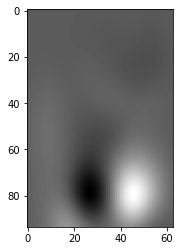

In [22]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[25, :, :, 0], cmap='gray')

In [23]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m3 = readvtk('ransacICPResult2_b_check.vtk')

view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [4]:
#finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

NameError: name 'final_transform' is not defined

(24, 48, 29, 3)


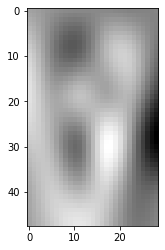

In [36]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')